# Predicting house prices

In this notebook we'll apply supervised Machine Learning (ML) models implemented in scikit-learn to predict house price data.

We'll be using data on houses in London, from ```10m_london_houses_.csv```.

## Contents
1. Data preprocessing
2. Predicting using only house size
3. Predicting using all data
4. Extracting the top features
5. Summary

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

print(np.NaN)

nan


In [150]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


Our data has 1000 rows and 17 columns (6 columns of numeric data and 11 of categoric data).

You can find a thorough analysis of them in the EDA notebook.

***
## 1 - Data preprocessing
***

Before any analysis, we need to prepare our data.

### 1.1 Encoding

First, encode the categorical data using dummy variables, since ```sklearn``` is designed only for numeric data.

We drop the 'Address' column, because most of its values are unique so it would blow up our feature set without adding much prediction power.

In [127]:
# Check how many unique values are in the addresses column
print(f'Unique addresses: {housing_df["Address"].nunique()}')

# Drop the Address column, apply get_dummies to the remaining columns
housing_df_encoded = pd.get_dummies(housing_df.drop(columns=['Address']),
                                       drop_first=True).astype(np.float32)

cols_encoded = housing_df_encoded.columns
print(f'Columns after encoding ({len(cols_encoded)}): {cols_encoded}')
housing_df_encoded.shape

Unique addresses: 770
Columns after encoding (36): Index(['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors',
       'Price (£)', 'Neighborhood_Chelsea', 'Neighborhood_Greenwich',
       'Neighborhood_Islington', 'Neighborhood_Kensington',
       'Neighborhood_Marylebone', 'Neighborhood_Notting Hill',
       'Neighborhood_Shoreditch', 'Neighborhood_Soho',
       'Neighborhood_Westminster', 'Garden_Yes', 'Garage_Yes',
       'Property Type_Detached House', 'Property Type_Semi-Detached',
       'Heating Type_Electric Heating', 'Heating Type_Gas Heating',
       'Heating Type_Underfloor Heating', 'Balcony_Low-level Balcony',
       'Balcony_No Balcony', 'Interior Style_Industrial',
       'Interior Style_Minimalist', 'Interior Style_Modern', 'View_Garden',
       'View_Park', 'View_Sea', 'View_Street', 'Materials_Laminate Flooring',
       'Materials_Marble', 'Materials_Wood', 'Building Status_Old',
       'Building Status_Renovated'],
      dtype='object')


(1000, 36)

### 1.2 Split into training and evaluation data
Second, let's set aside 100 randomly selected rows to be used for evaluating the model outputs later.

In [128]:
evaluation_set = housing_df_encoded.sample(frac=0.1, random_state=24)
train_test_df = housing_df_encoded.drop(evaluation_set.index).reset_index(drop=True)
evaluation_df = evaluation_set.reset_index(drop=True)

### 1.3 Create target and feature sets
Third, we separate out our features and target variable, and perform a train-test split on ```train_test_df```.

In [130]:
# Separate evluation_df into features and target variable
X_eval = evaluation_df.drop(columns=['Price (£)']).values
y_eval = evaluation_df['Price (£)'].values
# Separate train_test_df into features and target variable
X = train_test_df.drop(columns=['Price (£)']).values
y = train_test_df['Price (£)'].values

# Perform train-test split on X
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

print('Training data shape: ', X_test.shape, y_test.shape)
print('Test data shape: ', X_test.shape, y_test.shape)
print('Evaluation data shape: ', X_eval.shape, y_eval.shape)

Training data shape:  (270, 35) (270,)
Test data shape:  (270, 35) (270,)
Evaluation data shape:  (100, 35) (100,)


### 1.4 Scaling
Fourth and finally, scale the feature data using ```StandardScaler()```.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_eval_scaled = scaler.transform(X_eval)

Now we're ready to model!

***
## 2 - look only at house size
***
It's often mentioned that the most important factor in determining house prices is the size.

Let's take a look at that idea by building models trained only on the 'Square Meters' features.

In [131]:
# Get Square Meters data
X_train_sqm = X_train[:, cols_encoded.get_loc('Square Meters')].reshape(-1, 1)
X_test_sqm = X_test[:, cols_encoded.get_loc('Square Meters')].reshape(-1, 1)

# Instantiate models
models_sqm = {'Linear (SQM-only)': LinearRegression(),
            #   'Lasso (SQM-only)': Lasso(alpha = 0.1),
              'Ridge (SQM-only)': Ridge(alpha = 0.1)}

Next we fit the models to the training data, evaluate their $R^2$ score, and then generate and plot predictions using the test data.

We create a function for this since we will want to repeat it again later.

In [132]:
def score_predict_plot(model_dict, X_train, y_train, X_test, y_test, X_test1D, title='Model predictions'):
    """Fit and evaluate multiple models, plotting their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', marker='D',
                color='black', alpha=0.9, s=20)
    
    # Loop over models
    for model_name, model in model_dict.items():
        # Fit, redict and plot
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)
        # Calculate and print R² scores
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")
        
    plt.xlabel('Square meters [m^2]', fontsize=11)
    plt.ylabel('Price [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Linear (SQM-only) training--testing R²: 0.6412--0.6065
Ridge (SQM-only) training--testing R²: 0.6412--0.6065


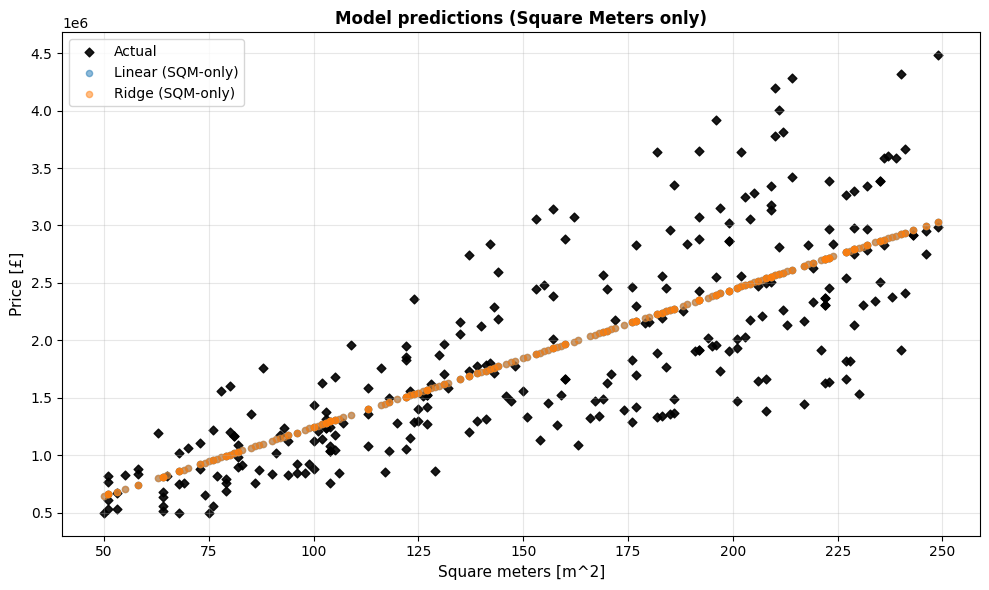

In [133]:
score_predict_plot(models_sqm,
                   X_train_sqm, y_train, X_test_sqm, y_test, X_test_sqm,
                   title='Model predictions (Square Meters only)')

The models have drawn a straight line through the data, as linear regression models are designed to do.

The models' $R^2$ scores of around 0.6 means they explain 60% of the variance in the data.

Let's go slightly deeper on the performance with some cross validation (CV).

In [135]:
from sklearn.model_selection import KFold, cross_val_score
kf20 = KFold(n_splits=10, shuffle=True, random_state=23)

print('CV scores: min--mean--max (std.)')
def cross_val_models(models_dict, X, y, cv):
    for model_name, model in models_dict.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
        print(f'{model_name}: {np.min(cv_scores):.3f} --- {np.mean(cv_scores):.3f} --- {np.max(cv_scores):.3f} ({cv_scores.std():.3f})')
    return

print('Training set:')
cross_val_models(models_sqm, X_train_sqm, y_train, kf20)
print('Test set:')
cross_val_models(models_sqm, X_test_sqm, y_test, kf20)

CV scores: min--mean--max (std.)
Training set:
Linear (SQM-only): 0.504 --- 0.629 --- 0.725 (0.065)
Ridge (SQM-only): 0.504 --- 0.629 --- 0.725 (0.065)
Test set:
Linear (SQM-only): 0.258 --- 0.571 --- 0.886 (0.158)
Ridge (SQM-only): 0.258 --- 0.571 --- 0.886 (0.158)


After cross-validating the model scores across 20 different data folds, we see $R^2$ can go pretty low, but is generally around 0.5-0.7 - not great, but not bad for a single feature.

Interestingly, the models all produce identical results and scores.

Now let's train the models using _all_ the data.

***
## 3 - look at all data
***
Let's now see how well the models can do with all the data available.

### 3.1 - fit, train, score

In [136]:
# Instantiate models for all features
models_all = {'Linear (All data)': LinearRegression(),
              'Lasso (All data)': Lasso(alpha = 0.1),
              'Ridge (All data)': Ridge(alpha = 0.1)}

# Fit each model and print R² scores
for model_name, model in models_all.items():
    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")

Linear (All data) training--testing R²: 0.9472--0.9505
Lasso (All data) training--testing R²: 0.9472--0.9505
Ridge (All data) training--testing R²: 0.9472--0.9505


/Users/matt/opt/anaconda3/envs/root_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.600e+11, tolerance: 4.880e+10
  model = cd_fast.enet_coordinate_descent(


Wow - a 50% increase in the $R^2$ values! The test and training $R^2$ values are also close, which is good because it implies we've avoided overfitting.

Now let's do some hyperparameter tuning for the Lasso and Ridge models (we'll ignore the convergence warning on the Lasso model for now).

### 3.2 Tuning

We'll use ```sklearn```'s ```RandomizedSearchCV``` function.

In [137]:
from sklearn.model_selection import RandomizedSearchCV

# Set the hyperparameter grids for Lasso and Ridge
params = {'alpha': np.linspace(0.001, 10, 100)}

randomCV_lasso_all = RandomizedSearchCV(models_all['Lasso (All data)'], params,
                                        cv=kf20, n_iter=20, random_state=24)
randomCV_ridge_all = RandomizedSearchCV(models_all['Ridge (All data)'], params,
                                        cv=kf20, n_iter=20, random_state=24)

models_all_cvs = {
    'Lasso (All data)': randomCV_lasso_all,
    'Ridge (All data)': randomCV_ridge_all
}

# Print the best scores and parameters
for name, model in models_all_cvs.items():
    model.fit(X_train_scaled, y_train)
    print('{} {} {}'.format(5*'-', name, 5*'-'))
    print(f'Top score: {model.best_score_:.4f}')
    print(f'Top params: {model.best_params_}')

----- Lasso (All data) -----
Top score: 0.9402
Top params: {'alpha': 9.495}
----- Ridge (All data) -----
Top score: 0.9403
Top params: {'alpha': 3.738}


We see the best performing models had alpha values of around:
- **9.50** for Lasso 
- **3.78** for Ridge.

Let's save those best models and see how the predictions look now using the plotting fucnction defined earlier.

Linear Regression (All data) training--testing R²: 0.9472--0.9505
Best Lasso (All data) training--testing R²: 0.9472--0.9505
Best Ridge (All data) training--testing R²: 0.9471--0.9501


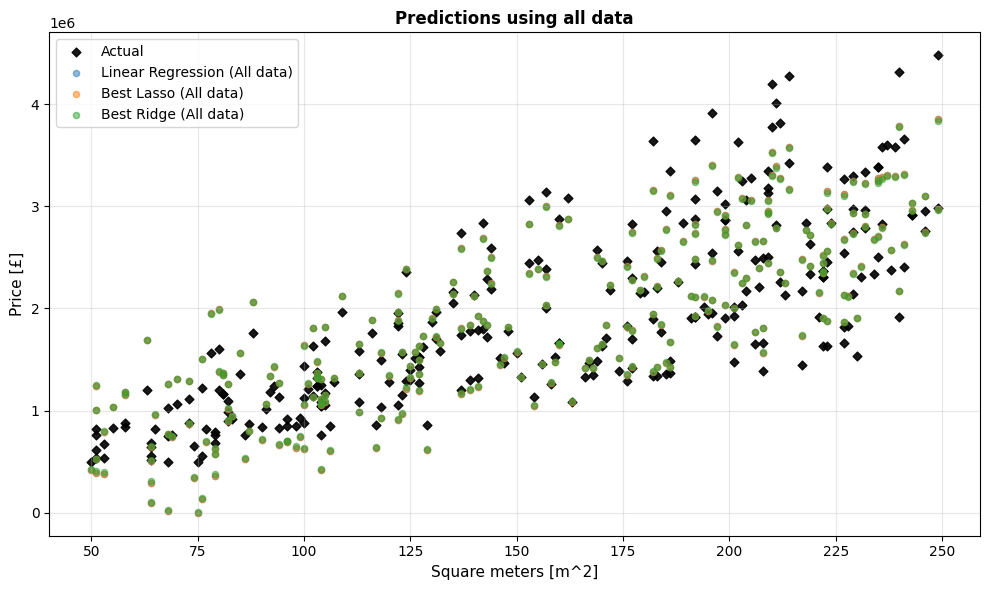

In [138]:
best_models = {
    'Linear Regression (All data)': models_all['Linear (All data)'],
    'Best Lasso (All data)': randomCV_lasso_all.best_estimator_,
    'Best Ridge (All data)': randomCV_ridge_all.best_estimator_
}

score_predict_plot(best_models,
                   X_train_scaled, y_train, X_test_scaled, y_test,
                   X_test_sqm, title='Predictions using all data')

The predictions look much better, especially in the middle (the lower the predictions are a bit too spread out and at the higher end they are too clustered, compared to the actual values).

### 3.3 Model Evaluation
Now that we are satisfied with our models, we can finally use our evaluation set to see how well they perform on unseen data.

First, let's plot how the model predictions of the evaluation data perform.

Linear Regression (All data) eval R²: 0.9374
Best Lasso (All data) eval R²: 0.9375
Best Ridge (All data) eval R²: 0.9372


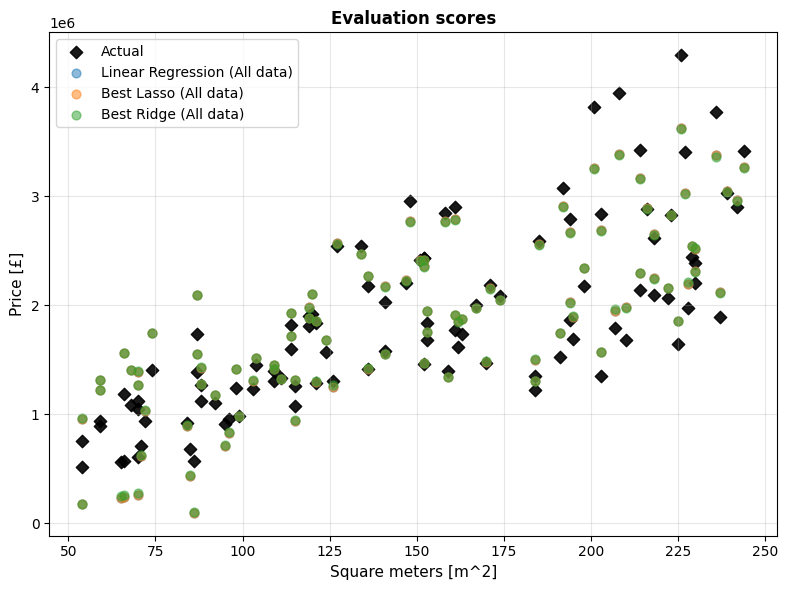

In [139]:
# Create figure and plot the actual results
plt.figure(figsize=(8, 6))
plt.scatter(X_eval[:, 2], y_eval, label='Actual', marker='D',
            color='black', alpha=0.9, s=40)

eval_set_preds = {}
# Loop over models
for model_name, model in best_models.items():
    # Predict and plot
    eval_set_preds[model_name] = model.predict(X_eval_scaled)
    plt.scatter(X_eval[:, 2], eval_set_preds[model_name], label=model_name, alpha=0.5, s=40)
    # Calculate and print R² scores
    eval_score = model.score(X_eval_scaled, y_eval)
    print(f"{model_name} eval R²: {eval_score:.4f}")
    
plt.xlabel('Square meters [m^2]', fontsize=11)
plt.ylabel('Price [£]', fontsize=11)
plt.title('Evaluation scores', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

$R^2$ remains high, which means the models do well at explaining the variation even in unseen data.

But how good are they at actually predicting house prices?

To understand this, we'll evluate the models on 3 key parameters:
- The Root Mean Squared Error (RMSE)
- The Mean Aboslute Error (MAE) - this tells us on average how close our models' estimates are in £.
- The Mean Aboslute Percentage Error (MAPE) - this tells us on average how close our models' estimates are in percentage terms.

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_models(model_dict, prediction_dict, y):
    '''Loop over a model dictionary and calculate the R2, RMSE, MAE and MAPE'''
    model_scores = {}
    for model_name in model_dict.keys():
        print(f'----- {model_name} -----')
        # Calculate metrics
        model_r2 = np.round(r2_score(y, prediction_dict[model_name]), 2)
        model_rmse = np.round(np.sqrt(mean_squared_error(y, prediction_dict[model_name])), 2)
        model_mae = np.round(mean_absolute_error(y, prediction_dict[model_name]), 2)
        model_mape = np.round(np.mean(np.abs((y - prediction_dict[model_name]) / y)) * 100, 2)
        # MSE
        print('R2 score:', model_r2)
        print(f'RMSE: £{model_rmse}')
        print(f'MAE: £{model_mae}')
        print(f'MAPE: {model_mape}%')
        # Save to dictionary
        model_scores[model_name] = [model_r2, model_rmse, model_mae, model_mape]
    return model_scores

Evaluate our best models.

In [36]:
eval_models(best_models, eval_set_preds, y_eval)

----- Linear Regression (All) -----
R2 score: 0.94
RMSE: £206933.88
MAE: £157327.52
MAPE: 11.74%
----- Best Lasso (All) -----
R2 score: 0.94
RMSE: £206915.37
MAE: £157316.56
MAPE: 11.74%
----- Best Ridge (All) -----
R2 score: 0.94
RMSE: £207397.17
MAE: £157655.86
MAPE: 11.63%


{'Linear Regression (All)': [0.94, 206933.88, 157327.52, 11.74],
 'Best Lasso (All)': [0.94, 206915.37, 157316.56, 11.74],
 'Best Ridge (All)': [0.94, 207397.17, 157655.86, 11.63]}

What do these results mean?

Well, despite the high $R^2$, the models still can't predict house prices that accurately. 
The Ridge model performs marginally better than the other with a MAPE of 11.64%, which is a sizeable margin of error. 
This translates to being _over £150,000 off_ the real price on averge - ouch!

Still the point is that these are simple models -- they're really the minimum of what Machine Learning has to offer, and they can still get within 12% of the real price.

With more complex models, more hyperparameter tuning and a larger dataset you could make much more accurate models.

***
## 4 - Feature Analysis
***

What can the models tell us about the most important factors in determining the house price?

We can evaluate the feature coefficients to find out.

### 4.1 - Feature coefficients

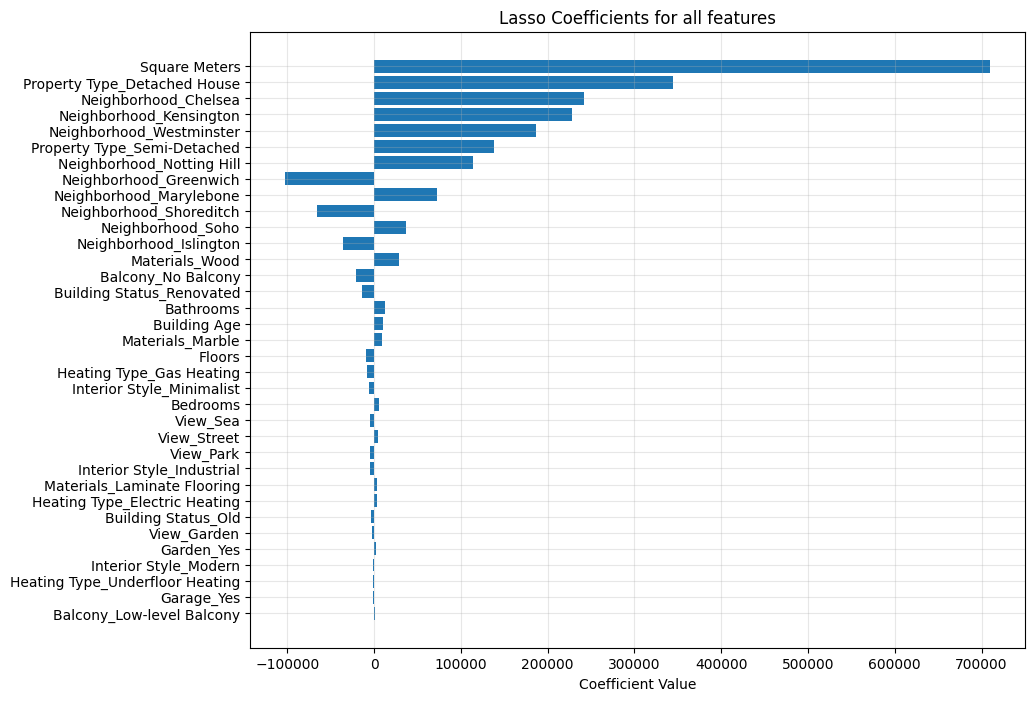

In [145]:
# Extract and sort the coefficient data
lasso_coeff = best_models['Best Lasso (All data)'].coef_
lasso_coef_df = pd.DataFrame([evaluation_df.drop(columns=['Price (£)']).columns, lasso_coeff]).transpose()
lasso_coef_df.columns=['Features', 'Coefficients']
lasso_coef_df['Abs. Coeff.'] = np.abs(lasso_coef_df['Coefficients'])

# Plot the coefficients, sorted by absolute value
plt.figure(figsize=(10, 8))
plt.barh(lasso_coef_df.sort_values('Abs. Coeff.')['Features'],
         lasso_coef_df.sort_values('Abs. Coeff.')['Coefficients'])
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for all features')
plt.grid(True, alpha=0.3)
plt.show()

What does this tell us?

Firstly, the size in square meters of a house has the biggest coefficient, as we might expect.

9 of the top 12 features are the neighbourhood a house is in. Note that the model thinks that areas like Islington are actually _bad_ for house prices, despite absolutely being sought after in real life - we can put this down to the training set including only high value areas, so naturally the least high value areas don't appear as good.

In the bottom end it seems that things like having a garden, a garage or a nice view do not affect price much.

Interestingly, the number of bedrooms and bathrooms also has little effect, perhaps because these features are effectively included in the Square Meters value.

### 4.2 Dimensionality Reduction

Let's see how well a model can do using just the top 12 features.

In [101]:
# Get top features
top_features = lasso_coef_df.sort_values('Abs. Coeff.', ascending=False)\
                .reset_index().loc[:11, :]['Features']
# Get the indices of the top features
top_feature_indices = lasso_coef_df[lasso_coef_df['Features'].isin(top_features)].index.tolist()
# Get the columns of the scaled feature sets for the top features
X_train_top = X_train_scaled[:, top_feature_indices]
X_test_top = X_test_scaled[:, top_feature_indices]
X_eval_top = X_eval_scaled[:, top_feature_indices]


Create and tune a new model on the top feature data.

In [146]:
randomCV_lasso_top = RandomizedSearchCV(Lasso(), params, cv=kf20,
                                        n_iter=20, random_state=24)
randomCV_lasso_top.fit(X_train_top, y_train)
print(f'Top score: {randomCV_lasso_top.best_score_:.4f}')
print(f'Top params: {randomCV_lasso_top.best_params_}')

Top score: 0.9421
Top params: {'alpha': 9.495}


Evaluate the new model

In [148]:
lasso_top_preds = randomCV_lasso_top.best_estimator_.predict(X_eval_top)
eval_models({'Lasso (top features)': randomCV_lasso_top.best_estimator_},
            {'Lasso (top features)': lasso_top_preds},
            y_eval)

----- Lasso (top features) -----
R2 score: 0.94
RMSE: £195373.73
MAE: £147393.95
MAPE: 10.79%


{'Lasso (top features)': [0.94, 195373.73, 147393.95, 10.79]}

Despite using 66% less data, the new model has in fact turned out marginally better than the previous models.

***
#### BONUS: Residual analysis
***

Getting a better understanding of how model predictions compare to the true values.

In [51]:
import scipy.stats as stats
residuals = {
    'LinReg': y_eval - eval_set_preds['Linear Regression (All)'],
    'Lasso': y_eval - eval_set_preds['Best Lasso (All)'],
    'Ridge': y_eval - eval_set_preds['Best Ridge (All)']
}

In [59]:
def plot_residuals(residuals_dict, predictions_dict, y_true, save_plots=False, verbose=True):
    """Plot residuals for multiple models."""
    fig = plt.figure(figsize=(16, 12))

    # 1. Residuals vs Predicted (Test Set)
    ax1 = plt.subplot(2, 3, 1)
    for model_name, residuals in residuals_dict.items():
        ax1.scatter(predictions_dict[model_name], residuals, alpha=0.5, s=20, label=model_name)
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted Price (£)')
    ax1.set_ylabel('Residuals (£)')
    ax1.set_title('Residuals vs Predicted (Test Set)')
    ax1.grid(True, alpha=0.3)

    # 2. Residuals vs Actual (Test Set)
    ax2 = plt.subplot(2, 3, 2)
    for model_name, residuals in residuals_dict.items():
        ax2.scatter(y_true, residuals, alpha=0.5, s=20, label=model_name)
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Actual Price (£)')
    ax2.set_ylabel('Residuals (£)')
    ax2.set_title('Residuals vs Actual (Test Set)')
    ax2.grid(True, alpha=0.3)

    # 3. Histogram of Residuals
    ax3 = plt.subplot(2, 3, 3)
    for model_name, residuals in residuals_dict.items():
        # ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, label=model_name)
        sns.histplot(residuals, kde=True, label=model_name, alpha=0.5)
    ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax3.set_xlabel('Residuals (£)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Residuals (Test Set)')
    ax3.grid(True, alpha=0.3)

    # 4. Q-Q Plot
    ax4 = plt.subplot(2, 3, 4)
    for model_name, residuals in residuals_dict.items():
        stats.probplot(residuals, dist="norm", plot=plt)
    ax4.set_title('Q-Q Plot (Normality Check)')
    ax4.grid(True, alpha=0.3)

    # 5. Scale-Location Plot (Sqrt of standardized residuals)
    ax5 = plt.subplot(2, 3, 5)
    for model_name, residuals in residuals_dict.items():
        standardized_residuals = residuals / np.std(residuals)
        ax5.scatter(y_true, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, s=20, label=model_name)
    ax5.set_xlabel('Predicted Price (£)')
    ax5.set_ylabel('√|Standardized Residuals|')
    ax5.set_title('Scale-Location Plot (Homoscedasticity Check)')
    ax5.grid(True, alpha=0.3)

    # 6. Predicted vs Actual
    ax6 = plt.subplot(2, 3, 6)
    for model_name, residuals in residuals_dict.items():
        ax6.scatter(y_true, predictions_dict[model_name], alpha=0.5, s=20, label=model_name)
    min_val = min(y_true.min(), y_true.min())
    max_val = max(y_true.max(), y_true.max())
    ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax6.set_xlabel('Actual Price (£)')
    ax6.set_ylabel('Predicted Price (£)')
    ax6.set_title('Predicted vs Actual (Test Set)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

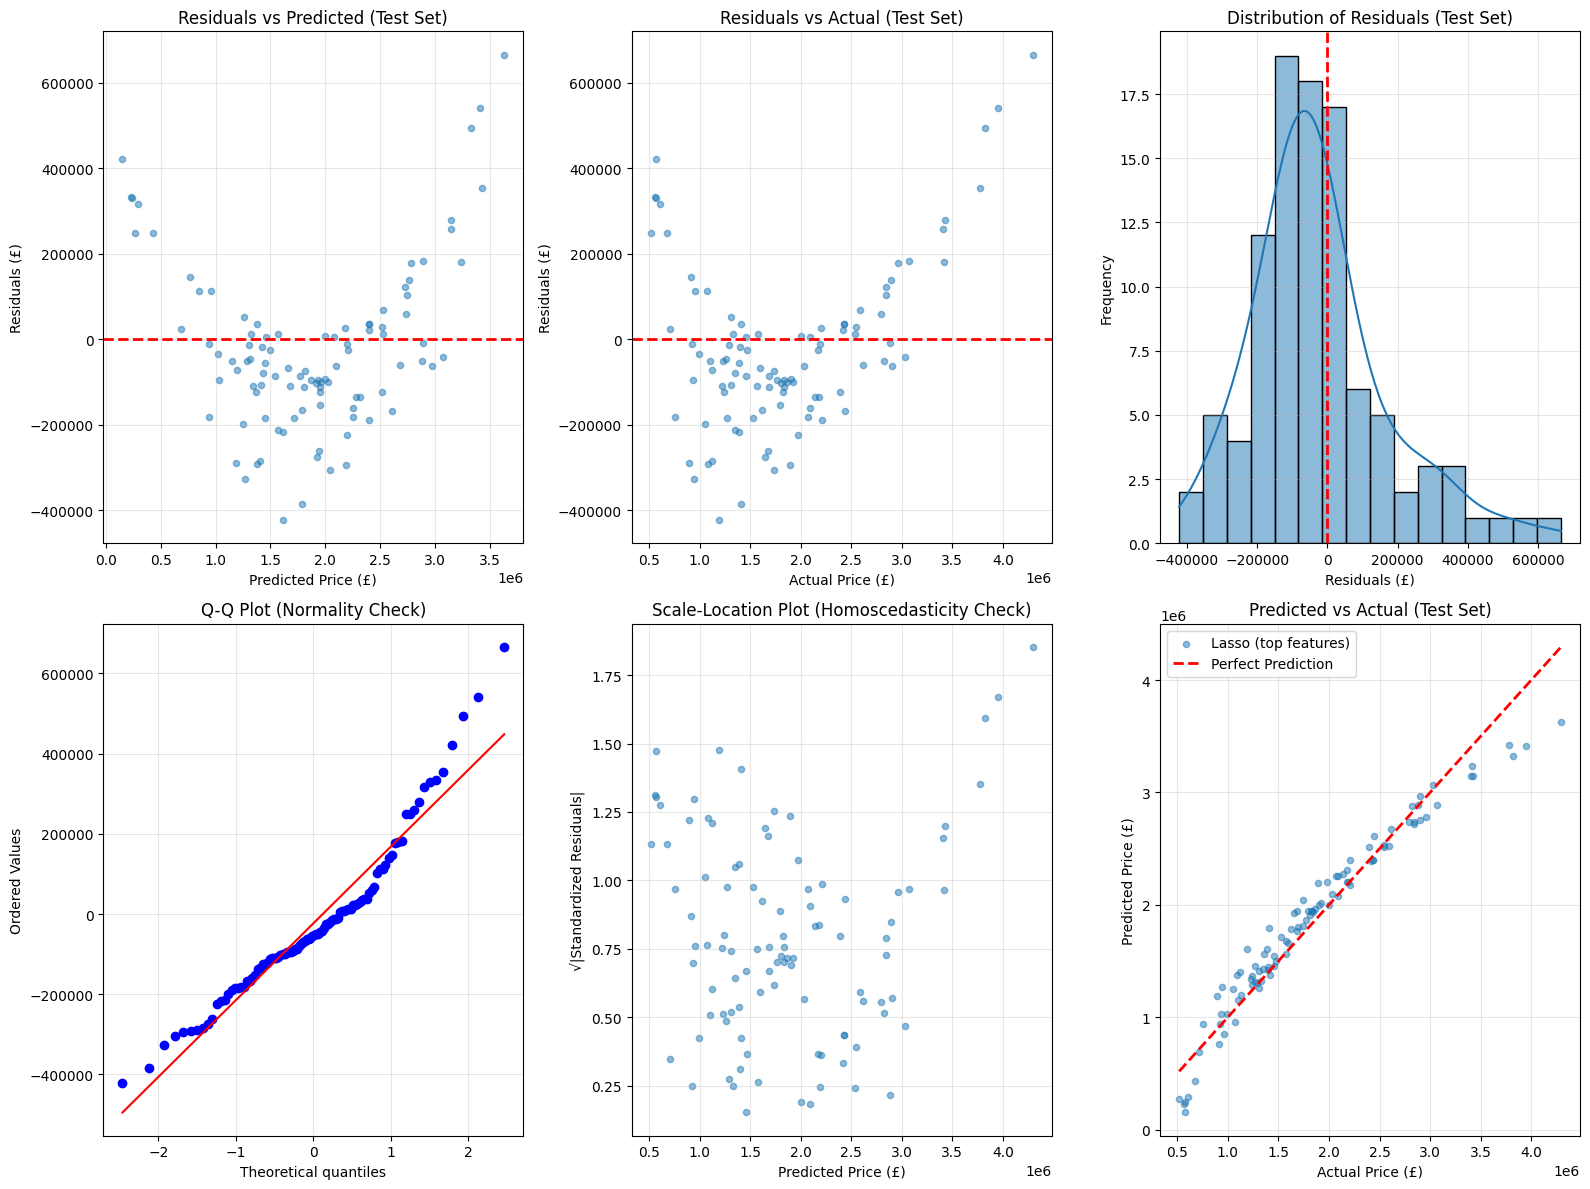

In [149]:
plot_residuals({'Lasso (top features)': y_eval - lasso_top_preds},
                {'Lasso (top features)': lasso_top_preds},
                y_eval)